In [1]:
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation

Dataset URL: https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation
License(s): other
 99% 171M/172M [00:05<00:00, 42.5MB/s]
100% 172M/172M [00:05<00:00, 34.5MB/s]


In [2]:
!unzip augmented-forest-segmentation.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segment

In [3]:
!pip install torchutils

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [5]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
# import segmentation_models_pytorch as smp
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary

import torchutils as tu
import matplotlib.pyplot as plt
from torch.nn.functional import relu

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import torch.utils.checkpoint as checkpoint

In [6]:
train_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(45),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor()
])

valid_transform = T.Compose([
    T.ToTensor()
])

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # Load image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

        # Convert to PIL Image for compatibility with T.Compose
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        # Apply transformations (both image and mask should have the same transformations)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [8]:
#Define Paths and Create Directories
image_dir = '/content/Forest Segmented/Forest Segmented/images'
mask_dir = '/content/Forest Segmented/Forest Segmented/masks'

output_dirs = {
    'train_images': '/content/Forest Segmented/train/images',
    'train_masks': '/content/Forest Segmented/train/masks',
    'val_images': '/content/Forest Segmented/val/images',
    'val_masks': '/content/Forest Segmented/val/masks',
    'test_images': '/content/Forest Segmented/test/images',
    'test_masks': '/content/Forest Segmented/test/masks',
}

for path in output_dirs.values():
    os.makedirs(path, exist_ok=True)

In [9]:
#Get List of Files
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

np.random.seed(42)
indices = np.random.permutation(len(image_files))
image_files = np.array(image_files)[indices]
mask_files = np.array(mask_files)[indices]

In [10]:
#Split into train (70%), val (15%), and test (15%)
train_images, test_images, train_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.3, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    test_images, test_masks, test_size=0.5, random_state=42
)

In [11]:
#Move Files to Corresponding Directories
def move_files(files, src_dir, dst_dir):
    for file_name in files:
        shutil.move(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))

move_files(train_images, image_dir, output_dirs['train_images'])
move_files(train_masks, mask_dir, output_dirs['train_masks'])

move_files(val_images, image_dir, output_dirs['val_images'])
move_files(val_masks, mask_dir, output_dirs['val_masks'])

move_files(test_images, image_dir, output_dirs['test_images'])
move_files(test_masks, mask_dir, output_dirs['test_masks'])

In [12]:
# Apply augmentations only to the training dataset
train_dataset = SegmentationDataset(
    image_dir='/content/Forest Segmented/train/images',
    mask_dir='/content/Forest Segmented/train/masks',
    transform=train_transform
)

# No augmentation for validation and test datasets
valid_dataset = SegmentationDataset(
    image_dir='/content/Forest Segmented/val/images',
    mask_dir='/content/Forest Segmented/val/masks',
    transform=valid_transform
)

test_dataset = SegmentationDataset(
    image_dir='/content/Forest Segmented/test/images',
    mask_dir='/content/Forest Segmented/test/masks',
    transform=valid_transform
)

In [13]:
# Set up your batch size
batch_size = 32

# Create DataLoaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [15]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        # Encoder with reduced number of filters
        self.e11 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # Decoder with corresponding reductions
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        # Use checkpointing for memory-intensive layers with explicit `use_reentrant`
        xe11 = F.relu(checkpoint.checkpoint(self.e11, x, use_reentrant=False))
        xe12 = F.relu(checkpoint.checkpoint(self.e12, xe11, use_reentrant=False))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(checkpoint.checkpoint(self.e21, xp1, use_reentrant=False))
        xe22 = F.relu(checkpoint.checkpoint(self.e22, xe21, use_reentrant=False))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(checkpoint.checkpoint(self.e31, xp2, use_reentrant=False))
        xe32 = F.relu(checkpoint.checkpoint(self.e32, xe31, use_reentrant=False))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(checkpoint.checkpoint(self.e41, xp3, use_reentrant=False))
        xe42 = F.relu(checkpoint.checkpoint(self.e42, xe41, use_reentrant=False))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(checkpoint.checkpoint(self.e51, xp4, use_reentrant=False))
        xe52 = F.relu(checkpoint.checkpoint(self.e52, xe51, use_reentrant=False))

        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(checkpoint.checkpoint(self.d11, xu11, use_reentrant=False))
        xd12 = F.relu(checkpoint.checkpoint(self.d12, xd11, use_reentrant=False))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(checkpoint.checkpoint(self.d21, xu22, use_reentrant=False))
        xd22 = F.relu(checkpoint.checkpoint(self.d22, xd21, use_reentrant=False))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(checkpoint.checkpoint(self.d31, xu33, use_reentrant=False))
        xd32 = F.relu(checkpoint.checkpoint(self.d32, xd31, use_reentrant=False))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(checkpoint.checkpoint(self.d41, xu44, use_reentrant=False))
        xd42 = F.relu(checkpoint.checkpoint(self.d42, xd41, use_reentrant=False))

        out = self.outconv(xd42)

        return out

In [16]:
model = UNet(n_class = 1)

In [17]:
for param in model.parameters():
    param.requires_grad_(True)

In [18]:
model.to(DEVICE)

UNet(
  (e11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(256, 512, kernel_size=(3, 3)

In [34]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [35]:
def iou(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

In [36]:
def fit(
        model: torch.nn.Module,
        n_epochs: int,
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        criterion: torch.nn.Module
        ) -> tuple[list, ...]:

    train_loss = []
    valid_loss = []
    train_iou = []
    valid_iou = []

    model.to(DEVICE)

    for epoch in range(n_epochs):
        print(f"{'-' * 13} Epoch {epoch+1} {'-' * 13}")

        model.train()
        train_epoch_loss = []
        train_epoch_iou = []

        for images, labels in train_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            y_pred = model(images)

            # Calculate loss
            loss = criterion(y_pred, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate metrics
            pred_labels = torch.sigmoid(y_pred) > 0.5  # Assuming binary segmentation
            iou_score = iou(pred_labels.float(), labels.float())

            train_epoch_loss.append(loss.item())
            train_epoch_iou.append(iou_score.item())

        train_loss.append(np.mean(train_epoch_loss))
        train_iou.append(np.mean(train_epoch_iou))

        # Validation phase
        model.eval()
        valid_epoch_loss = []
        valid_epoch_iou = []

        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                # Forward pass
                y_pred = model(images)

                # Calculate loss
                loss = criterion(y_pred, labels)

                # Calculate metrics
                pred_labels = torch.sigmoid(y_pred) > 0.5
                iou_score = iou(pred_labels.float(), labels.float())

                valid_epoch_loss.append(loss.item())
                valid_epoch_iou.append(iou_score.item())

        valid_loss.append(np.mean(valid_epoch_loss))
        valid_iou.append(np.mean(valid_epoch_iou))

        print(
          f'Train: IoU {train_iou[-1]:.3f}, loss {train_loss[-1]:.3f}\n'
          f'Valid: IoU {valid_iou[-1]:.3f}, loss {valid_loss[-1]:.3f}')
        print(f'{"-"*35}')

        # Clean up after each epoch
        # del images, labels, y_pred, loss
        # torch.cuda.empty_cache()

    return train_loss, valid_loss, train_iou, valid_iou


In [37]:
logs = fit(model, 8, optimizer, train_loader, valid_loader, criterion)

------------- Epoch 1 -------------
Train: IoU 0.572, loss 0.575
Valid: IoU 0.589, loss 0.565
-----------------------------------
------------- Epoch 2 -------------
Train: IoU 0.578, loss 0.572
Valid: IoU 0.598, loss 0.591
-----------------------------------
------------- Epoch 3 -------------
Train: IoU 0.575, loss 0.570
Valid: IoU 0.587, loss 0.579
-----------------------------------
------------- Epoch 4 -------------
Train: IoU 0.576, loss 0.568
Valid: IoU 0.585, loss 0.579
-----------------------------------
------------- Epoch 5 -------------
Train: IoU 0.573, loss 0.573
Valid: IoU 0.572, loss 0.616
-----------------------------------
------------- Epoch 6 -------------
Train: IoU 0.577, loss 0.566
Valid: IoU 0.559, loss 0.579
-----------------------------------
------------- Epoch 7 -------------
Train: IoU 0.575, loss 0.571
Valid: IoU 0.607, loss 0.574
-----------------------------------
------------- Epoch 8 -------------
Train: IoU 0.582, loss 0.562
Valid: IoU 0.598, loss 0.

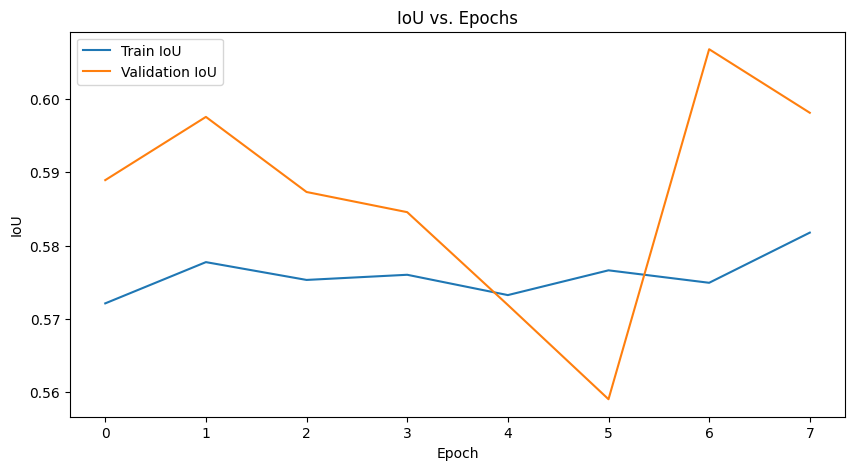

In [38]:
train_loss, valid_loss, train_iou, valid_iou = logs

# Plot IoU
plt.figure(figsize=(10, 5))
plt.plot(train_iou, label='Train IoU')
plt.plot(valid_iou, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU vs. Epochs')
plt.legend()
plt.show()

In [39]:
torch.save(model.state_dict(), 'model_weights.pth')

In [40]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

def evaluate(model, test_loader, criterion, device):
    model.to(device)
    model.eval()

    test_loss = []
    test_iou = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)
            loss = criterion(y_pred, labels)
            test_loss.append(loss.item())

            pred_labels = torch.sigmoid(y_pred) > 0.5
            iou_score = iou(pred_labels.float(), labels.float())
            test_iou.append(iou_score.item())

    avg_loss = np.mean(test_loss)
    avg_iou = np.mean(test_iou)

    return avg_loss, avg_iou

test_loss, test_iou = evaluate(model, test_loader, criterion, DEVICE)
print(f'Test: IoU {test_iou:.3f}, loss {test_loss:.3f}')

Test: IoU 0.621, loss 0.600
